In [1]:
from pprint import pprint
import io
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import time

from process_bigraph import Composite, ProcessTypes
from process_bigraph.emitter import emitter_from_wires, gather_emitter_results

from cdFBA import register_types
from cdFBA.utils import get_substrates, make_cdfba_composite

from spatial_transport.processes.diffusion import get_simple_diffusion_spec
from spatial_transport.processes.advection import get_simple_advection_spec
from spatial_transport import register_types as register_types2
from spatial_transport.utils import generate_voxels, generate_shared_environment, get_regular_edges, generate_simple_cdfba_composite, plot_concentrations_2d

In [2]:
exchanges = ['EX_lcts_e', 'EX_gal_e']
all_species = ['EX_lcts_e', 'EX_gal_e', 'deltaGal', 'deltaLac']
substrates = get_substrates(model_file="iAF1260", exchanges=exchanges)

model_dict = {
    'deltaGal':'E_no_galE.xml',
    'deltaLac':'E_no_LCTStex.xml'
}

voxels = generate_voxels([20,1,0], spacing=1)
edges = get_regular_edges(voxels, periodic=False, spacing=1)

compartments = generate_simple_cdfba_composite(voxels, model_dict, exchanges, 1, sub_range=(5,5), bio_range=(0.05,0.05))
for id, compartment in compartments.items():
    compartment["Shared Environment"]["counts"]["D-Galactose"] = 0
    compartment["Shared Environment"]["concentrations"]["D-Galactose"] = 0

spec = {"Compartments": compartments, "Edges": edges}

for species in model_dict.keys():
    substrates.append(species)

substrates_dict = {
    "Lactose C12H22O11": 0.03,
    "D-Galactose": 0.06,
    "deltaGal": 0.001,
    "deltaLac": 0.001
}

spec["Simple Diffusion"] = get_simple_diffusion_spec(
    substrates=substrates_dict,
    interval=0.1
)
spec["Simple Advection"] = get_simple_advection_spec(
    spacing=1,
    substrates=substrates,
    advection=[0.5, 0, 0],
    boundary="default",
    interval=0.1
)

spec["emitter"] = emitter_from_wires({
    "global_time": ["global_time"],
    'compartments': ["Compartments"],
})

pprint(spec)

core = ProcessTypes()
core = register_types(core)
core = register_types2(core)

sim = Composite(
    {
        "state": spec,
    },
    core=core
)
start_time = time.time()
sim.run(20)
print(f"{time.time() - start_time} seconds")
results = gather_emitter_results(sim)[("emitter",)]

{'Compartments': {'0': {'Shared Environment': {'concentrations': {'D-Galactose': 0,
                                                                  'Lactose C12H22O11': 5.0,
                                                                  'deltaGal': 0.05,
                                                                  'deltaLac': 0.05},
                                               'counts': {'D-Galactose': 0,
                                                          'Lactose C12H22O11': 5.0,
                                                          'deltaGal': 0.05,
                                                          'deltaLac': 0.05},
                                               'volume': 1},
                        'Species': {'deltaGal': {'_type': 'process',
                                                 'address': 'local:dFBA',
                                                 'config': {'bounds': {},
                                                            'cha

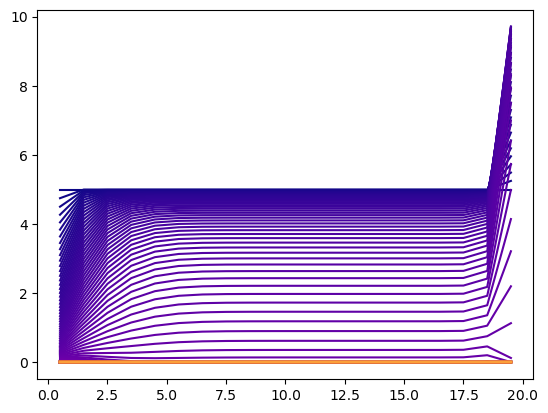

In [3]:
x_positions = [results[0]["compartments"][compartment]["position"][0] for compartment in
                   results[0]["compartments"].keys()]
lactose_conc = [[results[timepoint]["compartments"][compartment]["Shared Environment"]["concentrations"]["Lactose C12H22O11"] for compartment in results[0]["compartments"].keys()] for timepoint in range(len(results))]
colors = plt.cm.plasma.colors
for i, y in enumerate(lactose_conc):
    plt.plot(x_positions, y, color=colors[i])
plt.show()